<center><h1 style="background-color:#8ffaaa;font-family:newtimeroman;font-size:550%;text-align:center;border-radius: 15px 10px;padding: 5px"><b><u>Sentiment Analysis of COVID tweets</u></b></h1></center>
<center><div style="display: block; overflow:hidden;position: relative">
     <img src="https://miro.medium.com/max/450/1*p3Ste5R_iJzi5IcSmFkmtg.png" style="position: absolute;top: 0px;">
</div>

<h1><center>INTRODUCTION</center></h1>

The dataset comprises of tweets, specifically tweets related to Coronavirus, which have been pulled from Twitter and manual tagging has been done.

Sentiment analysis is performed on the dataset to classify the tweets into 3 classes - "Positive", "Neutral" and "Negative" using <b> LSTM Model. </b>


# 1.  Importing Libraries

In [ ]:
import pandas as pd
import numpy as np
import random

# for visualization
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# for text preprocessing
import re
import unicodedata
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical, plot_model

# for building the model
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping

# NLTK
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

# for measuring performance
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn import metrics

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/NLP Project')

# 2.  Loading the dataset

In [ ]:
df_train = pd.read_csv("/content/drive/MyDrive/NLP Project/Corona_NLP_train.csv", encoding="latin_1")
df_test = pd.read_csv("/content/drive/MyDrive/NLP Project/Corona_NLP_test.csv", encoding="latin_1")

# 3.  Data overview

In [ ]:
df_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
31671,35470,80422,"Varanasi, India",07-04-2020,And is not accepting that there are more than ...,Extremely Negative
17914,21713,66665,NaN,23-03-2020,@ChrisMurphyCT with so many needing SNAP right...,Neutral
7690,11489,56441,"Shenandoah Valley, VA",19-03-2020,@maxberger @DaiyoukaiGeisha @Daneuntamed #Canc...,Negative
28544,32343,77295,Mars,04-04-2020,My #CoronaProtection when going out since 12th...,Neutral
13087,16886,61838,Dagenham RM8,21-03-2020,Nice to see the holiday companies pushing pric...,Extremely Positive


In [ ]:
max_tweet_length = 0
tweet_length = []
#
for tweet in df_train["OriginalTweet"]:
    tweet_length.append(len(tweet))
    if len(tweet) > max_tweet_length:
        max_tweet_length = len(tweet)
print("Longest tweet: " + str(max_tweet_length) + " characters")

Longest tweet: 355 characters


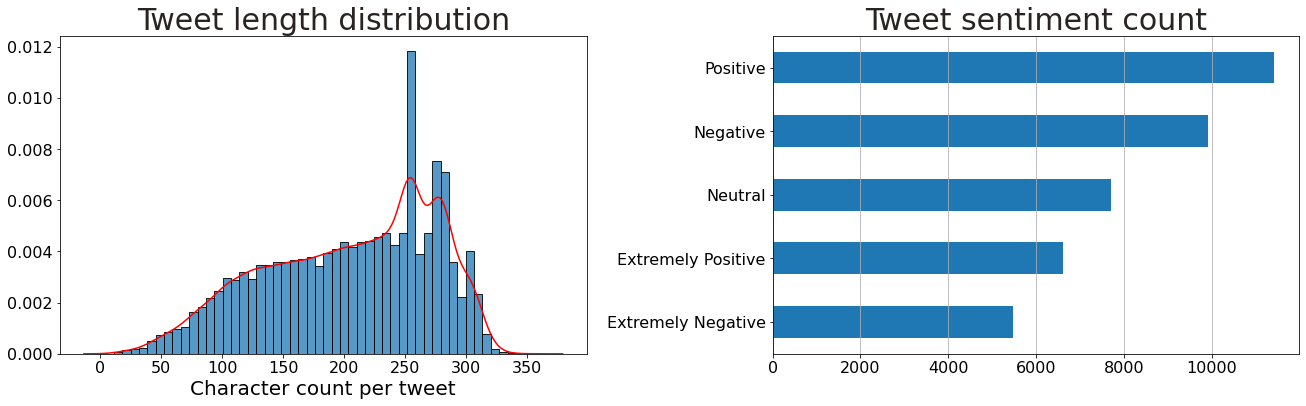

In [ ]:
parameters = {'axes.labelsize': 20,
              'axes.titlesize': 30}
#
plt.rcParams.update(parameters)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 6)
sns.histplot(tweet_length, palette='Blues', stat='density', bins=50, ax=ax1);
sns.kdeplot(tweet_length, color='red', ax=ax1)
ax1.set_xlabel('Character count per tweet');
df_train["Sentiment"].reset_index().groupby("Sentiment").count().rename(columns={"index": "Count"}).sort_values(by= 
       "Count").plot(kind="barh", legend=False, 
        ax=ax2).grid(axis='x')
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_ylabel("")
ax1.set_title("Tweet length distribution", color ="#292421")
ax2.tick_params(axis='x', labelsize=16)
ax2.tick_params(axis='y', labelsize=16)
ax2.set_ylabel("")
ax2.set_title("Tweet sentiment count", color ="#292421")
fig.tight_layout(pad=2.0)
plt.rcParams.update(parameters)

# 4.  Turning 5 categories into 3 categories
We convert <b>extremely positive</b> tweets into <b>positive</b> and <b>extremely negative</b> tweets into <b>negative</b>.

In [ ]:
def set_3_classes(x):
  if x=="Extremely Negative":
    return "Negative"
  elif x=="Extremely Positive":
    return "Positive"
  else:
    return x

In [ ]:
df_train["Sentiment"] = df_train["Sentiment"].apply(set_3_classes)
df_test["Sentiment"] = df_test["Sentiment"].apply(set_3_classes)

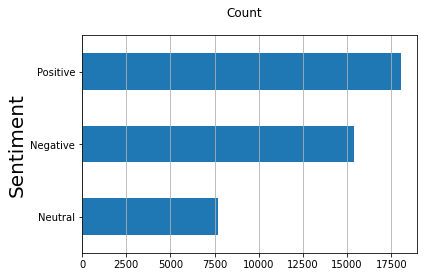

In [ ]:
fig, ax = plt.subplots()
fig.suptitle("Count", fontsize=12)
df_train["Sentiment"].reset_index().groupby("Sentiment").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

# 5. Cleaning tweets

In [ ]:
df_train["CleanTweet"] = df_train["OriginalTweet"]
df_train.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
27751,31550,76502,Global,03-04-2020,From @SPGMarketIntel: Global farming suffers f...,Negative,From @SPGMarketIntel: Global farming suffers f...
16613,20412,65364,NaN,22-03-2020,#Food will run out in some regions. Delivery #...,Neutral,#Food will run out in some regions. Delivery #...
27059,30858,75810,los angeles,02-04-2020,The shortage of key medical equipment is drivi...,Negative,The shortage of key medical equipment is drivi...


<b>Removing end-of-line, tabulation and carriage return. Turning into lower case:</b>

In [ ]:
def clean_eol_tabs(df, label):
    """ text lowercase
        removes \n
        removes \t
        removes \r """
    df[label] = df[label].str.lower()
    df[label] = df[label].apply(lambda x: x.replace("\n", " "))
    df[label] = df[label].apply(lambda x: x.replace("\r", " "))
    df[label] = df[label].apply(lambda x: x.replace("\t", " "))
    return df
#
df_train = clean_eol_tabs(df_train, "CleanTweet")

<b>Removing e-mails:</b>

In [ ]:
def remove_emails(df, label):
    """ This function removes email adresses
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"""(?:[a-z0-9!#$%&'*+/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+/=?^_`{|}~-]+)*|"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])""", " ", x))
    return df
#
df_train = remove_emails(df_train, "CleanTweet")

<b>Removing mentions:</b>

In [ ]:
def remove_mentions(df, label):
    """ This function removes mentions (Twitter - starting with @) from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"@([a-zA-Z0-9_.-]{1,100})", " ", x))
    return df
#
df_train = remove_mentions(df_train, "CleanTweet")

<b>Removing hyperlinks:</b>

In [ ]:
def remove_hyperlinks(df, label):
    """ This function removes hyperlinks from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"http\S+", " ", x))
    return df
#
df_train = remove_hyperlinks(df_train, "CleanTweet")

<b>Removing hashtags:</b>

In [ ]:
def remove_hashtags(df, label):
    """ This function removes hashtags
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"#\w+", " ", x))
    return df
#
df_train = remove_hashtags(df_train, "CleanTweet")

<b>Removing html tags:</b>

In [ ]:
def remove_html_tags(df, label):
    """ This function removes html tags from texts
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"<.*?>", " ", x))
    return df
#
df_train = remove_html_tags(df_train, "CleanTweet")

<b>Removing numbers:</b>

In [ ]:
def remove_numbers(df, label):
    """ This function removes numbers from a text
        inputs:
         - text """
    df[label] = df[label].apply(lambda x: re.sub(r"\d+", " ", x))
    return df
#
df_train = remove_numbers(df_train, "CleanTweet")

<b>Encoding unknown characters:</b>

In [ ]:
def encode_unknown(df, label):
    """ This function encodes special caracters """
    df[label] = df[label].apply(lambda x: unicodedata.normalize("NFD", x).encode('ascii', 'ignore').decode("utf-8"))
    return df
#
df_train = encode_unknown(df_train, "CleanTweet")

<b>Removing punctuations and accented characters:</b><br>

In [ ]:
def clean_punctuation_no_accent(df, label):
    """ This function removes punctuation and accented characters from texts in a dataframe 
        To be appplied to languages that have no accents, ex: english 
    """
    df[label] = df[label].apply(lambda x: re.sub(r'[^\w\s]', ' ', x))
    return df
#
df_train = clean_punctuation_no_accent(df_train, "CleanTweet")

<b>Removing stop words using nltk stopwords library:</b>

In [ ]:
def remove_stop_words(text, stopwords=set(stopwords.words('english'))):
    """ This function removes stop words from a text
        inputs:
         - stopword list
         - text """

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()
    
    # stop words updated
    #stopwords = stopwords.union({"amp", "grocery store", "covid", "supermarket", "people", "grocery", "store", "price", "time", "consumer"})
    
    # loop
    for word in text_splitted:
        if word not in stopwords:
            text_new.append(word)
    return " ".join(text_new)

def clean_stopwords(df, label):
    """ This function removes stopwords """
    df[label] = df[label].apply(lambda x: remove_stop_words(x))
    return df
#
df_train = clean_stopwords(df_train, "CleanTweet")

<b>Removing one and two letters words, removing unnecessary spaces, droping empty lines:</b>

In [ ]:
def more_cleaning(df, label):
    """ This function
     1) removes remaining one-letter words and two letters words
     2) replaces multiple spaces by one single space
     3) drop empty lines """
    df[label] = df[label].apply(lambda x: re.sub(r'\b\w{1,2}\b', " ", x))
    df[label] = df[label].apply(lambda x: re.sub(r"[ \t]{2,}", " ", x))
    df[label] = df[label].apply(lambda x: x if len(x) != 1 else '')
    df[label] = df[label].apply(lambda x: np.nan if x == '' else x)
    df = df.dropna(subset=[label], axis=0).reset_index(drop=True).copy()
    return df
#
df_train = more_cleaning(df_train, "CleanTweet")

<b>Lemmatizing words:</b><br>

In [ ]:
def lemmatize_one_text(text):
    """ This function lemmatizes words in text (it changes word to most close root word)
        inputs:
         - lemmatizer
         - text """

    # initialize lemmatizer
    lemmatizer = WordNetLemmatizer()
    
    # tags
    lem_tags = ['a', 'r', 'n', 'v']

    # prepare new text
    text_splitted = text.split(" ")
    text_new = list()

    # change bool
    changed = ''
    
    # loop
    for word in text_splitted:
        text_new.append(lemmatizer.lemmatize(word))

    return " ".join(text_new)

def lemmatize(df, label):
    """ This function lemmatizes texts """
    df[label] = df[label].apply(lambda x: lemmatize_one_text(x))
    return df
#
df_train = lemmatize(df_train, "CleanTweet")

In [ ]:
df_train.sample(5)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
31484,35324,80276,Uyo,06-04-2020,"No Electricity Supply, No money to even buy gr...",Negative,electricity supply money even buy grocery abi ...
20893,24723,69675,NaN,25-03-2020,As COVID 19 travels the world scam artists are...,Negative,covid travel world scam artist close behind ad...
31605,35446,80398,That shack outside La Grange,07-04-2020,A comprehensive guide to avoiding the grocery ...,Negative,comprehensive guide avoiding grocery store pha...
66,3867,48819,Melissa Schuman is a Liar ??,16-03-2020,@TinaMcCauley70 Yeah my parents are risky peop...,Positive,yeah parent risky people covid thatas stay ho...
24394,28225,73177,NaN,26-03-2020,Protective barriers being installed at #superm...,Neutral,protective barrier installed


### Cleaning the test data:

In [ ]:
df_test["CleanTweet"] = df_test["OriginalTweet"]
df_test = clean_eol_tabs(df_test, "CleanTweet")
df_test = remove_emails(df_test, "CleanTweet")
df_test = remove_mentions(df_test, "CleanTweet")
df_test = remove_hyperlinks(df_test, "CleanTweet")
df_test = remove_hashtags(df_test, "CleanTweet")
df_test = remove_html_tags(df_test, "CleanTweet")
df_test = remove_numbers(df_test, "CleanTweet")
df_test = encode_unknown(df_test, "CleanTweet")
df_test = clean_punctuation_no_accent(df_test, "CleanTweet")
df_test = clean_stopwords(df_test, "CleanTweet")
df_test = more_cleaning(df_test, "CleanTweet")
df_test = lemmatize(df_test, "CleanTweet")

In [ ]:
df_test.sample(3)

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,CleanTweet
1313,1314,46266,"Manchester, England",13-03-2020,Security guard on the mini hand-sanitisers in...,Positive,security guard mini hand sanitisers city centr...
376,377,45329,NaN,12-03-2020,"The world has shifted left, right and centre a...",Neutral,world shifted left right centre yet pakistani ...
1932,1933,46885,"West Orange, NJ",13-03-2020,When was the last time before this week you al...,Neutral,last time week went supermarket


In [ ]:
tweet_num = random.randint(0, df_train.shape[0])
print("############################# Original Tweet #############################")
print(df_train.iloc[tweet_num].at["OriginalTweet"])
print("\n")
print("############################# Clean Tweet ################################")
print(df_train.iloc[tweet_num].at["CleanTweet"])

############################# Original Tweet #############################
#coronavirus Boohoo are making us work in the warehouse even though some of us have underlying health conditions. Please boycott Boohoo!!! Remember this when you next think of doing online shopping. It isnÂt essential work. We need your help


############################# Clean Tweet ################################
 boohoo making work warehouse even though underlying health condition please boycott boohoo remember next think online shopping isnat essential work need help


In [ ]:
tweet_num = random.randint(0, df_train.shape[0])
print("############################# Original Tweet #############################")
print(df_train.iloc[tweet_num].at["OriginalTweet"])
print("\n")
print("############################# Clean Tweet ################################")
print(df_train.iloc[tweet_num].at["CleanTweet"])

############################# Original Tweet #############################



#CoronavirusPandemic #Coronavirus https://t.co/3yKsNPPncJ


############################# Clean Tweet ################################
 announces relief package decrease oil price oil price increased week 


# 6.  Viewing the data

<b>Sentiment repartition:</b>

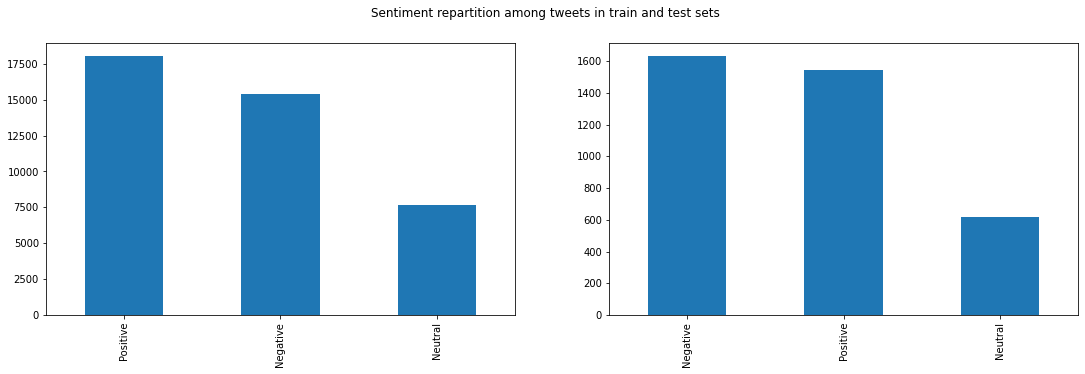

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 5)
fig.suptitle('Sentiment repartition among tweets in train and test sets')
df_train["Sentiment"].value_counts().plot(kind="bar", ax=ax1);
df_test["Sentiment"].value_counts().plot(kind="bar", ax=ax2);

<b>Word cloud in each sentiment categories:</b>

In [ ]:
all_words_positive = " ".join([text for text in df_train[df_train["Sentiment"]=="Positive"]["CleanTweet"]])
all_words_neutral = " ".join([text for text in df_train[df_train["Sentiment"]=="Neutral"]["CleanTweet"]])
all_words_negative = " ".join([text for text in df_train[df_train["Sentiment"]=="Negative"]["CleanTweet"]])

In [ ]:
wordcloud_positive = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Greens").generate(all_words_positive)
wordcloud_neutral = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="YlOrBr").generate(all_words_neutral)
wordcloud_negative = WordCloud(width=800, height=600, max_font_size=120, background_color="white", colormap="Reds").generate(all_words_negative)

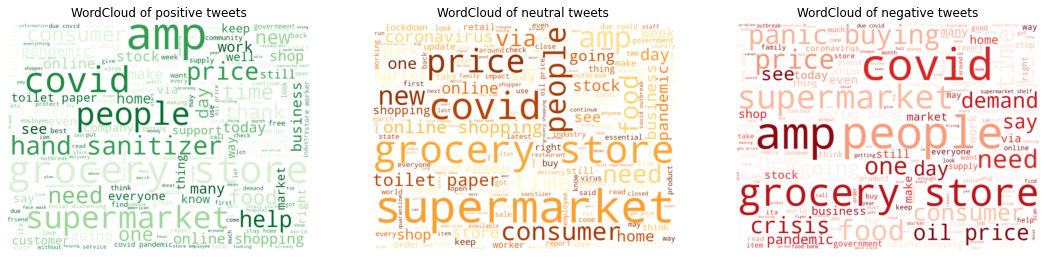

In [ ]:
parameters = {'axes.labelsize': 12,
              'axes.titlesize': 10}
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
fig.set_size_inches(18.5, 7)
ax1.imshow(wordcloud_positive, interpolation='bilinear')
ax1.axis("off")
ax1.set_title("WordCloud of positive tweets", fontsize=12)
ax2.imshow(wordcloud_neutral, interpolation='bilinear')
ax2.axis("off")
ax2.set_title("WordCloud of neutral tweets", fontsize=12)
ax3.imshow(wordcloud_negative, interpolation='bilinear')
ax3.axis("off")
ax3.set_title("WordCloud of negative tweets", fontsize=12)
plt.rcParams.update(parameters)
plt.show()

# 7. Sentiment encoding

In [ ]:
df_train_encoded = df_train.copy()
df_test_encoded = df_test.copy()
#
print("train set shape: " + str(df_train_encoded.shape))
print("test set shape: " + str(df_test_encoded.shape))

train set shape: (41100, 7)
test set shape: (3795, 7)


In [ ]:
map_sentiment = {"Neutral":0, "Positive":1,"Negative":2}
df_train_encoded['Sentiment'] = df_train_encoded['Sentiment'].map(map_sentiment)
df_test_encoded['Sentiment']  = df_test_encoded['Sentiment'].map(map_sentiment)

# 8. Feature and target preparation

In [ ]:
y_train = df_train['Sentiment'].copy()
y_test = df_test['Sentiment'].copy()
#
y_train_encoded = to_categorical(df_train_encoded['Sentiment'], 3)
y_test_encoded = to_categorical(df_test_encoded['Sentiment'], 3)
#
y_train_mapped = df_train_encoded['Sentiment'].copy()
y_test_mapped = df_test_encoded['Sentiment'].copy()
#
X_train = df_train_encoded[['CleanTweet']].copy()
X_test = df_test_encoded[['CleanTweet']].copy()

# 9. Tokenization, sequences, padding

<b>The result of tokenizer is a dictionnary with:</b><br>
* key = word<br>
* value = unique number

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train["CleanTweet"])
vocab_length = len(tokenizer.word_index) + 1
vocab_length

30445

The <b>texts_to_sequences</b> function first transforms a text into list of words. Then transforms list of list of words into list of list of numbers

In [ ]:
X_train = tokenizer.texts_to_sequences(X_train["CleanTweet"])
X_test = tokenizer.texts_to_sequences(X_test["CleanTweet"])

Each tweets has differents length. Thus the result of the <b>texts_to_sequences</b> function will be a list of list of numbers of different length: 

In [ ]:
print("First tweet encoded:")
print(X_train[0])
print("\nSecond tweet encoded:")
print(X_train[1])
print("\nThird tweet encoded:")
print(X_train[2])

First tweet encoded:
[387, 492, 1463, 96, 2123, 605, 260, 911, 303, 257, 605, 260, 1463, 352, 1620, 1892, 341, 11, 10, 781, 4020, 2618, 27, 854, 1977, 91]

Second tweet encoded:
[23, 769, 3734, 173, 220, 1235, 1526, 10, 105, 87, 1, 65]

Third tweet encoded:
[5, 25, 26, 133, 36, 18, 156, 5, 74, 59, 12, 45, 812, 45, 90]


To feed the deep learning model, we need all these lists to be the same length. Thus we need to apply padding. 

In [ ]:
max_word_count = 0
word_count = []
#
for encoded_tweet in X_train:
    word_count.append(len(encoded_tweet))
    if len(encoded_tweet) > max_word_count:
        max_word_count = len(encoded_tweet)
print("Maximum number of word in one tweet: " + str(max_word_count) + " words")

Maximum number of word in one tweet: 37 words


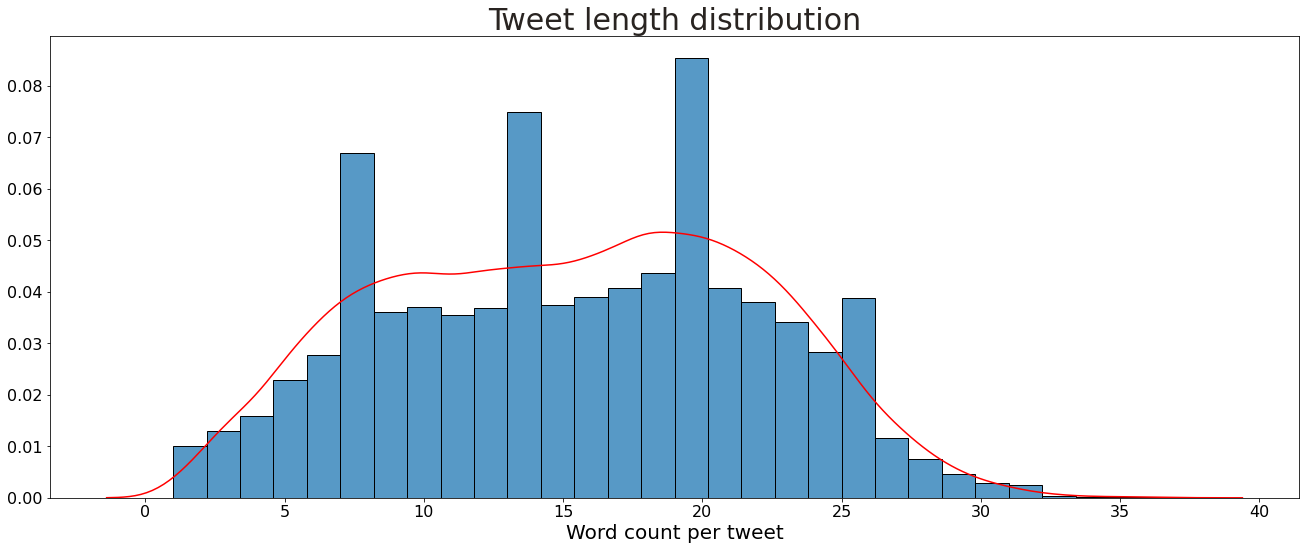

In [ ]:
parameters = {'axes.labelsize': 20,
              'axes.titlesize': 30}
#
plt.rcParams.update(parameters)
fig, ax1 = plt.subplots(1, 1)
fig.set_size_inches(18.5, 8)
sns.histplot(word_count, palette='Blues', stat='density', bins=30, ax=ax1);
sns.kdeplot(word_count, color='red', ax=ax1)
ax1.set_xlabel('Word count per tweet');
ax1.tick_params(axis='x', labelsize=16)
ax1.tick_params(axis='y', labelsize=16)
ax1.set_ylabel("")
ax1.set_title("Tweet length distribution", color ="#292421")
fig.tight_layout(pad=2.0)
plt.rcParams.update(parameters)

The longest tweetis composed of 37 words. So we will pad the sequences with a maximum length of 37.

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_word_count, padding='post')
X_test = pad_sequences(X_test, maxlen=max_word_count, padding='post')
X_train.shape

(41100, 37)

In [ ]:
print("First tweet encoded:", "Size = ", len(X_train[0]))
print(X_train[0])
print("\nSecond tweet encoded:", "Size = ", len(X_train[1]))
print(X_train[1])
print("\nThird tweet encoded:", "Size = ", len(X_train[2]))
print(X_train[2])

First tweet encoded: Size =  37
[ 387  492 1463   96 2123  605  260  911  303  257  605  260 1463  352
 1620 1892  341   11   10  781 4020 2618   27  854 1977   91    0    0
    0    0    0    0    0    0    0    0    0]

Second tweet encoded: Size =  37
[  23  769 3734  173  220 1235 1526   10  105   87    1   65    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]

Third tweet encoded: Size =  37
[  5  25  26 133  36  18 156   5  74  59  12  45 812  45  90   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0]


# 10. Model

<b>The model is composed of:</b>
1. <b>An embedding layer with parameters</b>
    * input dim = vocabulary size
    * output dim = 32
    * input length = size of padded sequences
    * mask_zero = True to ignore 0 (from padding)
2. <b>An LSTM (Long Short Term Memory) Layer with parameter</b>
    * units = 100 
3. <b>Three Dense layers</b>
4. <b>An output dense layer with parameters</b>
    * units = 3 (output dim)
    * activation = softmax (for multiclassification problem)

<b>Compilation with parameters:</b>
1. loss = categorical_crossentropy (for multiclassification problem)
2. optimizer = adam
3. metrics = accuracy

In [ ]:
model_LSTM = Sequential()
model_LSTM.add(layers.Embedding(vocab_length, output_dim=32, input_length=max_word_count, mask_zero=True))
model_LSTM.add(layers.LSTM(100))
model_LSTM.add(layers.Dense(64, activation="relu"))
model_LSTM.add(layers.Dense(32, activation="relu"))
model_LSTM.add(layers.Dense(16, activation="relu"))
model_LSTM.add(layers.Dense(3, activation='softmax'))
model_LSTM.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model_LSTM.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 37, 32)            974240    
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 64)                6464      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 51        
Total params: 1,036,563
Trainable params: 1,036,563
Non-trainable params: 0
______________________________________________

We introduce a callback function for early stopping after 10 epochs and set the parameter <i><b>restore_best_weights</b></i> to <b>True</b> so that the weights of best score on monitored metric - here <b>val_accuracy</b> (accuracy on test set) - are restored when training stops. This way the model has the best accuracy possible on unseen data.

In [ ]:
es = EarlyStopping(patience=10, monitor='val_accuracy', restore_best_weights=True)
history = model_LSTM.fit(X_train,
                         y_train_encoded,
                         validation_data=(X_test, y_test_encoded),
                         epochs=30,
                         batch_size=16,
                         verbose=1,
                         callbacks=[es]
                        )

Epoch 1/30
2569/2569 [==============================] - 133s 50ms/step - loss: 0.6076 - accuracy: 0.7447 - val_loss: 0.4599 - val_accuracy: 0.8395
Epoch 2/30
2569/2569 [==============================] - 126s 49ms/step - loss: 0.3243 - accuracy: 0.8930 - val_loss: 0.4466 - val_accuracy: 0.8453
Epoch 3/30
2569/2569 [==============================] - 126s 49ms/step - loss: 0.2367 - accuracy: 0.9239 - val_loss: 0.5117 - val_accuracy: 0.8393
Epoch 4/30
2569/2569 [==============================] - 126s 49ms/step - loss: 0.1790 - accuracy: 0.9419 - val_loss: 0.5487 - val_accuracy: 0.8306
Epoch 5/30
2569/2569 [==============================] - 127s 49ms/step - loss: 0.1377 - accuracy: 0.9535 - val_loss: 0.6844 - val_accuracy: 0.8142
Epoch 6/30
2569/2569 [==============================] - 129s 50ms/step - loss: 0.1010 - accuracy: 0.9648 - val_loss: 0.7915 - val_accuracy: 0.8103
Epoch 7/30
2569/2569 [==============================] - 127s 49ms/step - loss: 0.0777 - accuracy: 0.9732 - val_loss: 0

We can see that after epoch 2, the accuracy on test set - val_accuracy - starts to decrease while accuracy on train set continues to increase upto as high as 99.49%. This indicates that the model is overfitting after epoch 2 and is not able to generalize well on unseen validation data.

# 11. Model Evaluation

<b>Prediction on test set:</b>

In [ ]:
predicted = model_LSTM.predict(X_test)
y_pred = predicted.argmax(axis=-1)

<b>Calculation of accuracy and Area Under (ROC) Curve - AUC - scores:</b>

In [ ]:
acc_score = accuracy_score(y_test_mapped, y_pred)
auc_score = roc_auc_score(y_test_mapped, predicted, multi_class="ovr")

In [ ]:
print("Accuracy =", acc_score)
print("AUC =", auc_score)

Accuracy = 0.8453227931488801
AUC = 0.9397550088179436


<b>Classification report:</b>

In [ ]:
report = classification_report(y_test_mapped, y_pred, target_names=list(y_test.unique()), output_dict=True)
accuracy_col = ([""]*3) + [round(acc_score, 2)]
roc_auc_col = ([""]*3) + [round(auc_score, 2)]
accuracy_col = pd.Series(accuracy_col, index=list(report["Neutral"].keys()))
roc_auc_col = pd.Series(roc_auc_col, index=list(report["Neutral"].keys()))
df_report = pd.DataFrame(report)[["Neutral", "Positive", "Negative", "macro avg", "weighted avg"]].apply(lambda x: round(x, 2))
df_report["accuracy"] = accuracy_col
df_report["roc_auc"] = roc_auc_col
df_report

,Neutral,Positive,Negative,macro avg,weighted avg,accuracy,roc_auc
precision,0.82,0.87,0.87,0.85,0.85,,
recall,0.89,0.84,0.74,0.82,0.85,,
f1-score,0.85,0.85,0.80,0.84,0.84,,
support,1633.00,1546.00,616.00,3795.00,3795.00,0.85,0.94


<b>Confusion Matrix:</b>

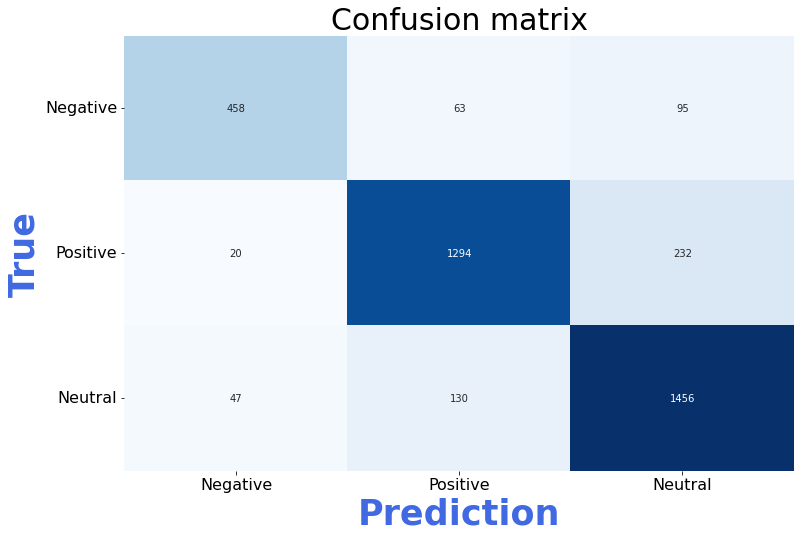

In [ ]:
## Plot confusion matrix
cm = confusion_matrix(y_test_mapped, y_pred)
fig, ax = plt.subplots()
fig.set_size_inches(12, 8)
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, cbar=False)
ax.set(xticklabels=list(y_test.unique()), yticklabels=list(y_test.unique()), title="Confusion matrix")
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)
ax.set_ylabel("True", color="royalblue", fontsize=35, fontweight=700)
ax.set_xlabel("Prediction", color="royalblue", fontsize=35, fontweight=700)
plt.yticks(rotation=0);

<b>ROC and precision-recall curves</b>

In [ ]:
y_test_array = pd.get_dummies(y_test_mapped, drop_first=False).values
classes = y_train.unique()

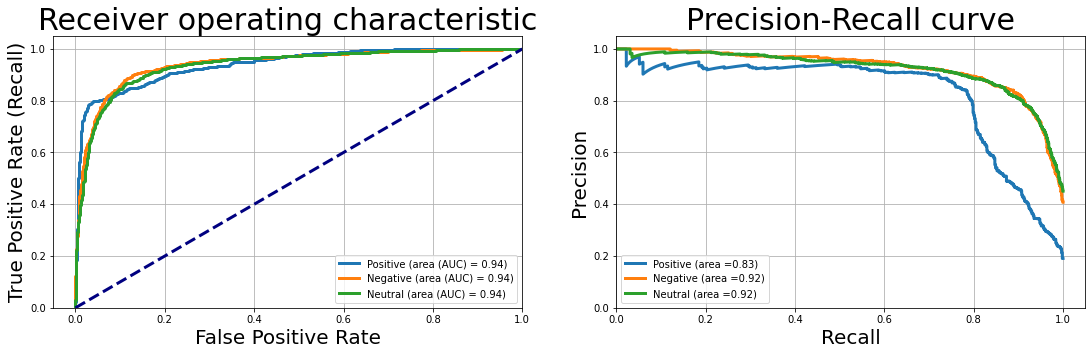

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=2)
fig.set_size_inches(18.5, 5)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = roc_curve(y_test_array[:,i], predicted[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area (AUC) = {1:0.2f})'.format(classes[i], metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="Receiver operating characteristic")
ax[0].legend(loc="lower right")
ax[0].grid(True)

## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], predicted[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area ={1:0.2f})'.format(classes[i], metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.show()